In [2]:
import numpy as np
import pandas as pd
import os

import re
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [1]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 491K Jan 15 18:18 data/69-.paralel.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  48M Jan 15 18:21 data/Russia.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  12M Jan 15 18:21 data/Sil_struktur.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  44K Jan 15 18:19 data/biblioteka.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  25M Jan 15 18:19 data/bivs.SSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 6.1M Jan 15 18:18 data/biznes.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 2.9M Jan 15 18:21 data/cennosti.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  28M Jan 15 18:21 data/economic.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  16M Jan 15 18:19 data/internet.i.smi.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 8.6M Jan 15 18:18 data/iz.jizni.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 125K Jan 15 18:18 data/kultprosvet.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko  20M Jan 15 18:18 data/kultura.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 

In [3]:
name_dataset = 'mir'

### load data

In [4]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(149880, 7)
CPU times: user 14.3 s, sys: 181 ms, total: 14.5 s
Wall time: 14.5 s


In [5]:
df = df[df.text!='text']
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/finnair/,NaN,Россия,Финны отказались летать в Россию на Новый год,Финская авиакомпания Finnair отменила рейсы из...,Мир
2,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/japan_nuclear/,NaN,Мир,"Ядерная авария в Японии: 55 облученных, цепная...","Японские власти заявили, что им удалось справи...",Мир


### preprocess

* get dates

In [6]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

<unknown>:2: DeprecationWarning: invalid escape sequence \d


CPU times: user 481 ms, sys: 20.4 ms, total: 502 ms
Wall time: 500 ms


* clean text

In [7]:
import preprocessing_tools as pr

In [8]:
%%time
df.text = df.text.apply(pr.clean_text)

CPU times: user 21.4 s, sys: 116 ms, total: 21.5 s
Wall time: 21.5 s


In [9]:
df.head(2)

,1914-lenta/,url,edition,topics,title,text,topic,date_raw,year,month
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/finnair/,NaN,Россия,Финны отказались летать в Россию на Новый год,финская авиакомпания finnair отменила рейсы из...,Мир,"[(1999, 10, 01)]",1999,10
2,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/japan_nuclear/,NaN,Мир,"Ядерная авария в Японии: 55 облученных, цепная...",японские власти заявили что им удалось справит...,Мир,"[(1999, 10, 01)]",1999,10


* cleanedNames

In [10]:
from cleanedNames import KeyProc
cn = KeyProc()

In [11]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

CPU times: user 3min 34s, sys: 11 ms, total: 3min 34s
Wall time: 3min 34s


* lemmatization

In [12]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

CPU times: user 5min 15s, sys: 296 ms, total: 5min 15s
Wall time: 5min 15s


* add docID

In [13]:
df['docID'] = list(range(df.shape[0]))

In [14]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
1,0,1999,10,"[финский, авиакомпания, finnair, отменить, рей..."
2,1,1999,10,"[японский, власть, удаться, справиться, произо..."


In [15]:
print(df.shape)
df.isnull().sum()

(149652, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [16]:
df.year.min()

1999

## model

* prepare

In [17]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 1.41 s, sys: 196 ms, total: 1.61 s
Wall time: 1.7 s


In [18]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [19]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/mir", num_batches=150)
CPU times: user 55.4 s, sys: 719 ms, total: 56.2 s
Wall time: 12 s


In [20]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [21]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=19de586a-f9c2-45c5-9124-325b5b548785, num_entries=41566)

In [22]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [ ]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

start = 6
end = 25
stepp = 1

for i in range(start,end+1,stepp):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    
    # 1st regularizer
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
    
    # 2st regularizer
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    # 3st regularizer
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)

In [ ]:
#model_list

In [ ]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [ ]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

In [ ]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

In [ ]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [ ]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

In [ ]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

In [ ]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [ ]:
perplexity

### select the best model

In [ ]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

In [ ]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-start]
print(best_model.num_topics)

---

In [23]:
select_topics = 17

In [24]:
num_topics = select_topics
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# 1st regularizer
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

# 2st regularizer
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

# 3st regularizer
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')


	SparsityThetaScore: 0.6430762410163879
	SparsityPhiScore: 0.8579622507095337
	PerplexityScore: 2962.400146484375


In [25]:
best_model = model.clone()
best_model.num_topics

17

---

### print top words for each topics

In [26]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['китай' 'остров' 'китайский' 'япония' 'судно' 'землетрясение' 'вода'
 'японский' 'корабль' 'судный']
topic_1: ['выбор' 'пост' 'парламент' 'кандидат' 'обама' 'выборы' 'голос'
 'премьерминистр' 'отставка' 'президентский']
topic_2: ['тюрьма' 'заключение' 'приговорить' 'германия' 'немецкий' 'признать'
 'преступление' 'адвокат' 'обвинять' 'виновный']
topic_3: ['израиль' 'израильский' 'палестинский' 'газа' 'палестинец' 'хамас'
 'сектор' 'автономия' 'израильтянин' 'иерусалим']
topic_4: ['франция' 'санкция' 'ес' 'украина' 'европейский' 'соглашение' 'евросоюз'
 'европа' 'германия' 'переговоры']
topic_5: ['самолёт' 'корея' 'кндр' 'аэропорт' 'борт' 'северный' 'пассажир' 'пилот'
 'южный' 'экипаж']
topic_6: ['оборона' 'самолёт' 'вооружение' 'истребитель' 'поставка' 'ввс' 'ракета'
 'система' 'нато' 'вертолёт']
topic_7: ['афганистан' 'пакистан' 'саудовский' 'алькаеда' 'аравия' 'пакистанский'
 'бин' 'афганский' 'талиб' 'талибан']
topic_8: ['оон' 'ирак' 'документ' 'буш' 'администрация' 'докла

### get topics-docs matrix

shape theta: (17, 149594)


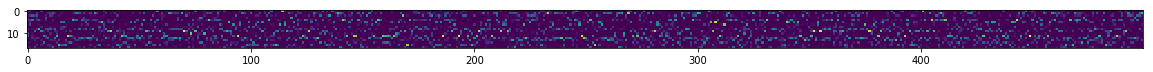

In [27]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [28]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
131000,0.000000,0.000000,0.171698,0.000000,0.621880,0.000000,0.029019,0.00000,0.000000,0.000000,0.0,0.054628,0.014739,0.000000,0.099481,0.00,0.008554
131001,0.000000,0.000000,0.000000,0.000000,0.102092,0.000000,0.000000,0.00000,0.095876,0.000000,0.0,0.725789,0.000000,0.020533,0.055710,0.00,0.000000
131002,0.092159,0.274112,0.020706,0.136751,0.000436,0.000000,0.000583,0.00000,0.000000,0.000000,0.0,0.041443,0.062467,0.069395,0.002506,0.05,0.249443
131003,0.089008,0.000000,0.000000,0.000000,0.000000,0.559164,0.000000,0.05009,0.000000,0.183758,0.0,0.012203,0.093440,0.000000,0.000000,0.00,0.012338
131004,0.000000,0.000000,0.000000,0.000000,0.061489,0.717063,0.046758,0.00000,0.091858,0.000000,0.0,0.000000,0.082832,0.000000,0.000000,0.00,0.000000


## DataViz

In [29]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
1,0,1999,10,0.551389,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.373155,0.000000,0.0,0.075456,0.000000,0.000000,0.000000,0.000000
2,1,1999,10,0.000000,0.000000,0.176032,0.0,0.000000,0.0,0.007088,0.006925,0.0,0.366398,0.000000,0.0,0.000000,0.350156,0.000000,0.081878,0.011522
3,2,1999,10,0.472199,0.000000,0.007969,0.0,0.009506,0.0,0.000000,0.000000,0.0,0.443457,0.007965,0.0,0.000000,0.000000,0.000000,0.000000,0.058906
4,3,1999,10,0.077684,0.000000,0.000000,0.0,0.000000,0.0,0.013928,0.039787,0.0,0.421806,0.116920,0.0,0.141850,0.000000,0.122568,0.065456,0.000000
5,4,1999,10,0.000000,0.308072,0.124981,0.0,0.069383,0.0,0.000000,0.000000,0.0,0.303550,0.000000,0.0,0.000000,0.000000,0.000000,0.194014,0.000000


In [30]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (228, 17)


topic_0    topic_1    topic_2   topic_3    topic_4    topic_5  \
year month                                                                    
1999 8       0.000000   0.000000   0.024625  0.000000   0.000000   0.000000   
     9      14.959619   4.652649   9.430069  3.201577  10.289398   9.843381   
     10     13.202132  15.148039  16.495741  2.814898  21.300106   8.052810   
     11     13.619324  11.288840  13.071228  4.389775  22.556427  10.089682   
     12     14.114790  12.361893  14.139478  1.559619  15.219007  10.340646   

             topic_6   topic_7    topic_8    topic_9  topic_10  topic_11  \
year month                                                                 
1999 8      0.000000  0.169674   0.000000   1.199115  0.000000  0.000000   
     9      3.716595  4.762003  18.032349  22.329039  4.904700  3.778806   
     10     7.251946  5.943290  22.120615  18.718790  3.950772  2.588515   
     11     8.568913  7.917380  19.592607  23.535782  4.524383  2.493579   
     12     5.486785  5.803030  15.791477  20.136625  8.128343  3.938536   

             topic_12   topic_13  topic_14   topic_15   topic_16  
year month                                                        
1999 8       0.166409   0.061411  0.242756   0.090043   0.045966  
     9       9.403858   9.958072  7.942288   9.508141  14.287457  
     10     14.385154  11.036277  8.586563   6.911739  14.492611  
     11     16.508471  13.861337  6.944089  10.065845  11.972342  
     12     16.916613  13.012470  6.877460   8.351308   9.821922

### straightforward matrix heatmap

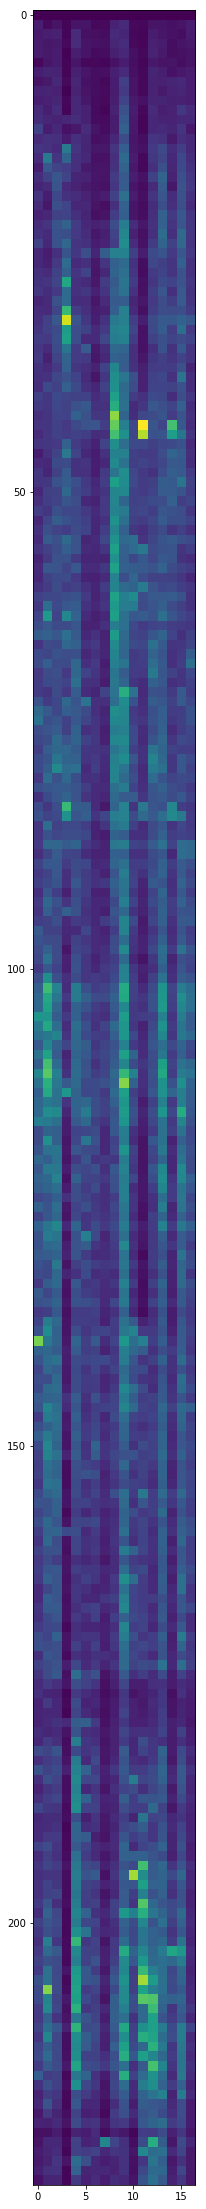

In [31]:
plt.figure(figsize=(10, 40))
plt.imshow(gb[topics])

## pygal

In [32]:
import pygal
from IPython.display import SVG, HTML

In [33]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [34]:
max(gb['topic_1'].values)

147.1976

In [ ]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [46]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [37]:
import joypy # !pip install joypy

In [38]:
print(joined.shape)
joined.head()

(149652, 20)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
1,0,1999,10,0.551389,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.373155,0.000000,0.0,0.075456,0.000000,0.000000,0.000000,0.000000
2,1,1999,10,0.000000,0.000000,0.176032,0.0,0.000000,0.0,0.007088,0.006925,0.0,0.366398,0.000000,0.0,0.000000,0.350156,0.000000,0.081878,0.011522
3,2,1999,10,0.472199,0.000000,0.007969,0.0,0.009506,0.0,0.000000,0.000000,0.0,0.443457,0.007965,0.0,0.000000,0.000000,0.000000,0.000000,0.058906
4,3,1999,10,0.077684,0.000000,0.000000,0.0,0.000000,0.0,0.013928,0.039787,0.0,0.421806,0.116920,0.0,0.141850,0.000000,0.122568,0.065456,0.000000
5,4,1999,10,0.000000,0.308072,0.124981,0.0,0.069383,0.0,0.000000,0.000000,0.0,0.303550,0.000000,0.0,0.000000,0.000000,0.000000,0.194014,0.000000


In [39]:
joined['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined[['year', 'month']].values]
cols = [c for c in joined.columns if c.startswith('topic')]

joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,date
1,0,1999,10,0.551389,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.373155,0.000000,0.0,0.075456,0.000000,0.000000,0.000000,0.000000,1999-10-01
2,1,1999,10,0.000000,0.000000,0.176032,0.0,0.000000,0.0,0.007088,...,0.0,0.366398,0.000000,0.0,0.000000,0.350156,0.000000,0.081878,0.011522,1999-10-01
3,2,1999,10,0.472199,0.000000,0.007969,0.0,0.009506,0.0,0.000000,...,0.0,0.443457,0.007965,0.0,0.000000,0.000000,0.000000,0.000000,0.058906,1999-10-01
4,3,1999,10,0.077684,0.000000,0.000000,0.0,0.000000,0.0,0.013928,...,0.0,0.421806,0.116920,0.0,0.141850,0.000000,0.122568,0.065456,0.000000,1999-10-01
5,4,1999,10,0.000000,0.308072,0.124981,0.0,0.069383,0.0,0.000000,...,0.0,0.303550,0.000000,0.0,0.000000,0.000000,0.000000,0.194014,0.000000,1999-10-01


In [40]:
dd = joined[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd.head()

,date,topic,mentions
0,1999-10-01,topic_0,0.551389
2,1999-10-01,topic_0,0.472199
3,1999-10-01,topic_0,0.077684
5,1999-10-01,topic_0,0.053641
11,1999-10-01,topic_0,0.616250


In [41]:
dd2 = dd.groupby(['date','topic']).sum()
dd2.head()

mentions
date       topic             
1999-08-01 topic_12  0.166409
           topic_13  0.061411
           topic_14  0.242756
           topic_15  0.090043
           topic_16  0.045966

In [42]:
dd2=dd2.reset_index()
dd2.head()

,date,topic,mentions
0,1999-08-01,topic_12,0.166409
1,1999-08-01,topic_13,0.061411
2,1999-08-01,topic_14,0.242756
3,1999-08-01,topic_15,0.090043
4,1999-08-01,topic_16,0.045966


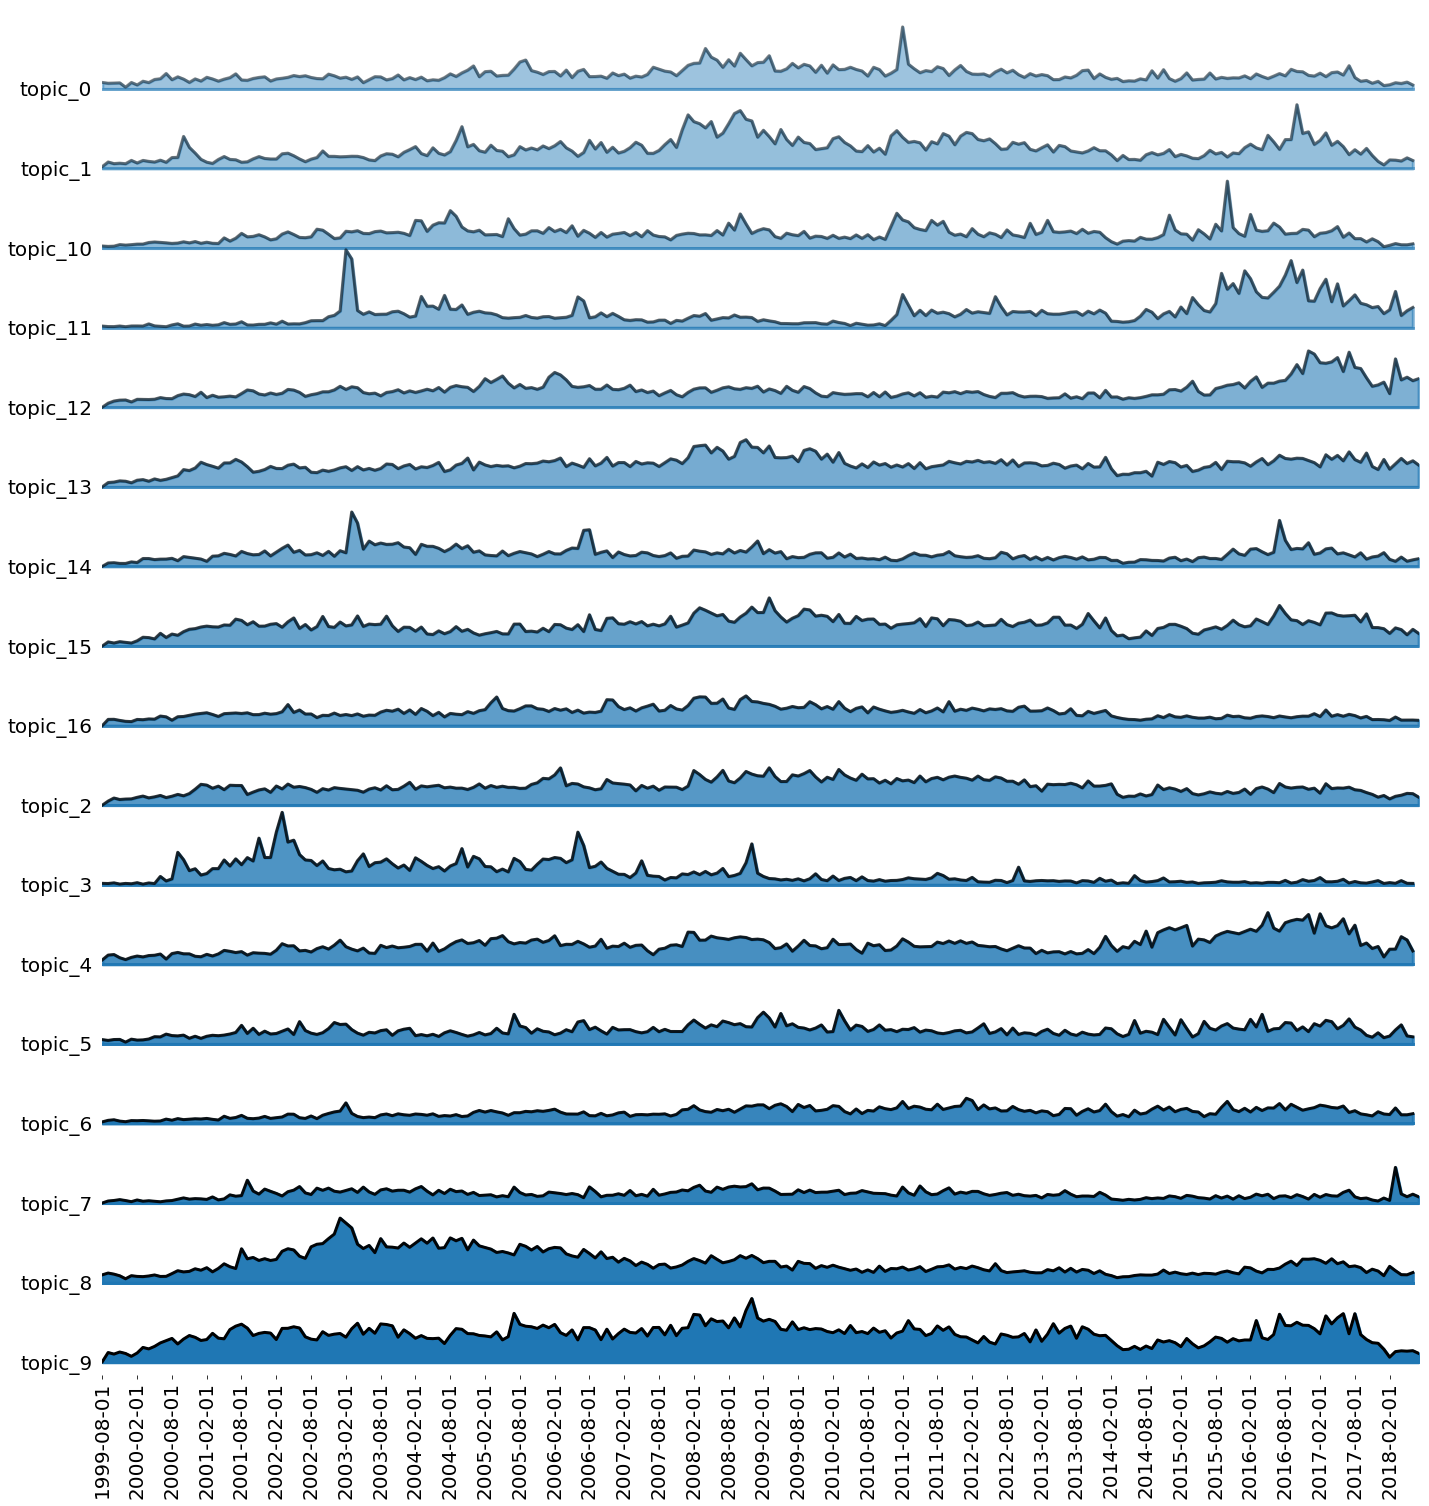

In [43]:
labels = sorted(joined['date'].unique())
fig, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [45]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")